# Probabilistic ML 
Author: Ahsan Mir

### Imports

In [674]:
import warnings

warnings.simplefilter(action='ignore')

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as lab
from scipy.optimize import curve_fit
import pandas as pd
from scipy.stats import hmean
from scipy.stats.mstats import gmean
from scipy.optimize import minimize
from scipy.stats import multivariate_normal 
from scipy.linalg import inv
from scipy.stats import norm
from tqdm import tqdm

Some fitting and prediction helper functions are borrowed from the original implementation

In [675]:
def fit_log(X, y, noise=None):
    
    assert X.shape[0] == y.shape[0], "X dim and y dim must match"
    assert (noise is None) or (noise.shape[0] == X.shape[0]), "Must input noise weight for each data point"
    
    n = X.shape[0]
    
    if isinstance(noise, np.ndarray):
        D = np.diag(1 / noise ** 2)
    else:
        D = np.identity(n)
    
    X = np.log(X)
    X = np.vstack((X, np.ones(X.shape[0]))).T
    w_opt = np.linalg.solve(X.T @ D @ X, X.T @ D @ y)
    return w_opt

def predict_log(x, w):
    """
    General purpose logarithmic evaluator given weights w = [a, b]
    For our purposes, this function maps (concentration) ==> (impedance)
    
    Input: variable x, weights w = (a, b)
    Output: a * log(x) + b
    """
    a, b = w
    return a * np.log(x, dtype=np.float64) + b

def predict_exp(x, w):
    """
    General purpose exponential evaluator given weights w = [a, b]
    This is the inverse of function y = a * log(x) + b
    For our purposes, this function maps (impedance) ==> (concentration)
    
    Input: variable x, weights w = (a, b)
    Output: exp( (y - b) / a )
    """
    a, b = w
    return np.exp( x / a - b / a)
    

### Experimental Data: Ingestion & Wrangling

In [676]:
filename = r"Yeast measurement 20220211 (Clean).csv"
df = pd.read_csv(filename)
df.head(28)

,freq / Hz,Z (Yeast - weird),Z (Yeast1),Z (Yeast2),Z (Yeast3),Z (Yeast4),Z (1:4 Yeast1),Z (1:4 Yeast2),Z (1:4 Yeast3),Z (Base1),Z (Base2),Z (Base3),Z (unknown)
0,50000.000,664000.0,735000.0,657000.0,658000.0,729000.0,661000.0,657000.0,683000.0,694000.0,695000.0,724000.0,677000.0
1,39369.820,774000.0,855000.0,771000.0,772000.0,844000.0,777000.0,773000.0,798000.0,820000.0,820000.0,826000.0,775000.0
2,30999.650,962000.0,1070000.0,960000.0,951000.0,1040000.0,966000.0,966000.0,998000.0,1020000.0,1020000.0,1010000.0,958000.0
3,24409.020,1260000.0,1440000.0,1260000.0,1280000.0,1370000.0,1290000.0,1300000.0,1350000.0,1350000.0,1370000.0,1370000.0,1280000.0
4,19219.570,1480000.0,1670000.0,1490000.0,1480000.0,1570000.0,1520000.0,1510000.0,1550000.0,1580000.0,1580000.0,1670000.0,1430000.0
5,15133.420,1830000.0,2090000.0,1870000.0,1860000.0,1930000.0,1890000.0,1880000.0,1940000.0,1970000.0,1970000.0,2070000.0,1700000.0
6,11916.000,2650000.0,2800000.0,2500000.0,2470000.0,2510000.0,2430000.0,2490000.0,2640000.0,2690000.0,2540000.0,2800000.0,2090000.0
7,9382.620,2710000.0,3260000.0,2860000.0,2930000.0,2910000.0,2830000.0,2830000.0,3070000.0,3060000.0,3000000.0,3300000.0,2260000.0
8,7387.840,3500000.0,4150000.0,3650000.0,3630000.0,3570000.0,3680000.0,3690000.0,3690000.0,3760000.0,3750000.0,3730000.0,2690000.0
9,5817.160,6080000.0,5080000.0,4540000.0,4560000.0,4320000.0,4470000.0,4500000.0,4590000.0,4590000.0,4540000.0,3780000.0,2950000.0


In [677]:
df.describe()

,freq / Hz,Z (Yeast - weird),Z (Yeast1),Z (Yeast2),Z (Yeast3),Z (Yeast4),Z (1:4 Yeast1),Z (1:4 Yeast2),Z (1:4 Yeast3),Z (Base1),Z (Base2),Z (Base3),Z (unknown)
count,27.000000,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01
mean,8696.633704,7.315185e+06,1.105630e+07,1.526696e+07,2.403263e+07,8.321963e+06,1.130200e+07,1.152096e+07,9.531815e+06,8.007185e+06,7.945741e+06,5.059259e+06,1.353333e+07
std,13209.499079,7.464259e+06,7.889018e+06,1.371882e+07,2.655963e+07,5.595371e+06,8.929663e+06,9.157509e+06,6.830165e+06,5.125978e+06,5.100194e+06,2.731999e+06,2.006733e+07
min,100.000000,6.640000e+05,7.350000e+05,6.570000e+05,6.580000e+05,7.290000e+05,6.610000e+05,6.570000e+05,6.830000e+05,6.940000e+05,6.950000e+05,7.240000e+05,6.770000e+05
25%,476.251000,2.680000e+06,3.030000e+06,2.680000e+06,2.700000e+06,2.710000e+06,2.630000e+06,2.660000e+06,2.855000e+06,2.875000e+06,2.770000e+06,3.050000e+06,2.175000e+06
50%,2236.070000,7.640000e+06,1.100000e+07,1.040000e+07,1.120000e+07,8.530000e+06,9.590000e+06,9.550000e+06,9.210000e+06,8.790000e+06,8.690000e+06,4.940000e+06,4.150000e+06
75%,10649.310000,9.265000e+06,1.915000e+07,2.830000e+07,4.255000e+07,1.405000e+07,2.035000e+07,2.040000e+07,1.655000e+07,1.325000e+07,1.305000e+07,7.515000e+06,1.685000e+07
max,50000.000000,4.070000e+07,2.110000e+07,3.910000e+07,8.110000e+07,1.540000e+07,2.510000e+07,2.590000e+07,1.950000e+07,1.400000e+07,1.400000e+07,8.950000e+06,7.830000e+07


In [678]:
freqs = np.flip(df.iloc[:,0].to_numpy())
concentrations = np.array([0.01, 0.25, 1])

print('Frequency Range ->', freqs)
print('Number of frequencies ->', len(freqs))
print('Concentrations ->', list(concentrations))

yeast_samp = np.flip(df.iloc[:,[2,3,4,5]].to_numpy(), axis=0)
yeast1_4_samp = np.flip(df.iloc[:,[6,7,8]].to_numpy(), axis=0)
base_samp = np.flip(df.iloc[:,[9,10,11]].to_numpy(), axis=0)

yeast = np.mean(yeast_samp, axis=1)
yeast1_4 = np.mean(yeast1_4_samp, axis=1)
base = np.mean(base_samp, axis=1)

Z = np.vstack((base, yeast1_4, yeast))

print("Shape of Impedance Matrix ->", Z.shape)

yeast_noise = np.std(yeast_samp, axis=1)
yeast1_4_noise = np.std(yeast1_4_samp, axis=1)
base_noise = np.std(base_samp, axis=1)

noise = np.vstack((base_noise, yeast1_4_noise, yeast_noise))

print("Shape of Noise Matrix ->", noise.shape)


Frequency Range -> [  100.      127.      161.291   204.842   260.151   330.394   419.603
   532.899   676.786   859.524  1091.6    1386.35   1760.67   2236.07
  2839.82   3606.6    4580.41   5817.16   7387.84   9382.62  11916.
 15133.42  19219.57  24409.02  30999.65  39369.82  50000.   ]
Number of frequencies -> 27
Concentrations -> [0.01, 0.25, 1.0]
Shape of Impedance Matrix -> (3, 27)
Shape of Noise Matrix -> (3, 27)


In [679]:
noise_at_freq = np.mean(noise, axis=0)
print(noise_at_freq.shape)

(27,)


In [680]:
SIGMA_EPSILON = noise_at_freq
NUM_FREQUENCIES = len(freqs)
NUM_PARAMS = 2 # alpha and beta

weights = np.empty((NUM_FREQUENCIES, NUM_PARAMS))

for i in range(NUM_FREQUENCIES): 
    
    w_i = fit_log(concentrations, Z[:,i], noise[:,i])
    weights[i] = w_i

print(weights)

[[ 3.16563942e+06  2.65452658e+07]
 [ 3.29093050e+06  2.71642120e+07]
 [ 3.17189123e+06  2.66440199e+07]
 [ 3.44548975e+06  2.80127386e+07]
 [ 2.92623461e+06  2.53974895e+07]
 [ 2.72880698e+06  2.42103549e+07]
 [ 2.60318435e+06  2.33296180e+07]
 [ 2.42826018e+06  2.22161762e+07]
 [ 2.13665781e+06  2.04231028e+07]
 [ 1.84189068e+06  1.86846073e+07]
 [ 1.42669481e+06  1.62948663e+07]
 [ 1.14332244e+06  1.41571710e+07]
 [ 9.26062345e+05  1.27103891e+07]
 [ 6.09373005e+05  1.02943274e+07]
 [ 4.60682930e+05  8.61722763e+06]
 [ 2.52061351e+05  7.02337029e+06]
 [ 1.31276237e+05  5.70200521e+06]
 [ 6.94118998e+04  4.61662535e+06]
 [-1.85896239e+04  3.66094821e+06]
 [-4.03111387e+04  2.91163488e+06]
 [-3.23652077e+04  2.51162597e+06]
 [-2.65373426e+04  1.87394157e+06]
 [-2.25095648e+04  1.49924453e+06]
 [-1.33458948e+04  1.30160994e+06]
 [-1.08718928e+04  9.66456826e+05]
 [-1.08515239e+04  7.71940407e+05]
 [-9.42758427e+03  6.58762909e+05]]


At this point, we have formatted the data, fitted our weights on the cleaned experimental data, and extracted our noise variance from it. Now we begin the probabilistic implementation. 

### Defining Priors 

The means of the priors are the fitted weights themselves. We assume the initial variance (10% of the mean squared).

In [681]:
MU_ALPHA = weights[:, 0]
MU_BETA = weights[:, 1]

SIGMA_ALPHA = 0.1 * np.abs(MU_ALPHA)  
SIGMA_BETA = 0.1 * np.abs(MU_BETA)    

for i in range(len(freqs)):

    print(f"Frequency {freqs[i]} Hz:")

    print(f"  Prior for alpha_{i}: N(mean={MU_ALPHA[i]:.2e}, std={SIGMA_ALPHA[i]:.2e})")
    print(f"  Prior for beta_{i}: N(mean={MU_BETA[i]:.2e}, std={SIGMA_BETA[i]:.2e})")

Frequency 100.0 Hz:
  Prior for alpha_0: N(mean=3.17e+06, std=3.17e+05)
  Prior for beta_0: N(mean=2.65e+07, std=2.65e+06)
Frequency 127.0 Hz:
  Prior for alpha_1: N(mean=3.29e+06, std=3.29e+05)
  Prior for beta_1: N(mean=2.72e+07, std=2.72e+06)
Frequency 161.291 Hz:
  Prior for alpha_2: N(mean=3.17e+06, std=3.17e+05)
  Prior for beta_2: N(mean=2.66e+07, std=2.66e+06)
Frequency 204.842 Hz:
  Prior for alpha_3: N(mean=3.45e+06, std=3.45e+05)
  Prior for beta_3: N(mean=2.80e+07, std=2.80e+06)
Frequency 260.151 Hz:
  Prior for alpha_4: N(mean=2.93e+06, std=2.93e+05)
  Prior for beta_4: N(mean=2.54e+07, std=2.54e+06)
Frequency 330.394 Hz:
  Prior for alpha_5: N(mean=2.73e+06, std=2.73e+05)
  Prior for beta_5: N(mean=2.42e+07, std=2.42e+06)
Frequency 419.603 Hz:
  Prior for alpha_6: N(mean=2.60e+06, std=2.60e+05)
  Prior for beta_6: N(mean=2.33e+07, std=2.33e+06)
Frequency 532.899 Hz:
  Prior for alpha_7: N(mean=2.43e+06, std=2.43e+05)
  Prior for beta_7: N(mean=2.22e+07, std=2.22e+06)
Freq

### Max A Posteriori (MAP) Estimation

MAP estimates of our parameters tell us the peak of the Gaussian approximation of the posterior. To compute them, we now define and compute our combined log-posterior and (combined log likelihood + log priors) to set up a optimization problem. Minimizing the negative log posterior (same as maximizing the log-posterior but scipy optimizers minimize so we adopt this adjustment) gives us the MAP estimates. 

In [682]:
NOISE_VARIANCE = SIGMA_EPSILON ** 2

def combined_log_posterior(params, Z, concentrations, noise_variance, MU_ALPHA, SIGMA_ALPHA, MU_BETA, SIGMA_BETA):
    """
    Compute the combined log posterior for all samples.
    
    Parameters:
    params: array of alpha and beta combined, shape (54,) - 27 alpha, 27 beta
    Z: 2D array of observed impedance values (3 samples, 27 frequencies)
    concentrations: array of true concentrations for each sample
    noise_variance: variance of noise at each frequency
    
    Returns:
    combined_log_posterior_value: the combined log posterior for all samples
    """

    alpha = params[:NUM_FREQUENCIES]
    beta = params[NUM_FREQUENCIES:] 
    
    total_log_likelihood = 0
    
    for i in range(Z.shape[0]):
        C_true = concentrations[i]
        Z_true = Z[i, :]
        
        Z_predicted = alpha * np.log(C_true) + beta
        residual = Z_true - Z_predicted
        
        log_likelihood_value = -0.5 * np.sum((residual**2) / noise_variance + np.log(2 * np.pi * noise_variance))
        
        total_log_likelihood += log_likelihood_value

    log_prior_alpha = np.sum(norm.logpdf(alpha, MU_ALPHA, SIGMA_ALPHA))
    log_prior_beta = np.sum(norm.logpdf(beta, MU_BETA, SIGMA_BETA))    
    log_posterior = total_log_likelihood + log_prior_alpha + log_prior_beta
    
    return -log_posterior

initial_params = np.hstack((MU_ALPHA, MU_BETA))

result = minimize(combined_log_posterior, initial_params, args=(Z, list(concentrations), NOISE_VARIANCE, MU_ALPHA, SIGMA_ALPHA, MU_BETA, SIGMA_BETA), method='L-BFGS-B')

if result.success:
    print("Optimization was successful!")
else:
    print("Optimization failed.")

ALPHA_MAP = result.x[:27] 
BETA_MAP = result.x[27:]  

print("MAP estimates of alpha:", ALPHA_MAP)
print("MAP estimates of beta:", BETA_MAP)

Optimization was successful!
MAP estimates of alpha: [3165639.42415517 3290930.49685535 3171891.2312182  3445489.74844929
 2926234.61201913 2728806.98359994 2602773.51139162 2428260.18481194
 2136657.81489969 1841890.67982647 1426694.81076263 1143322.44486839
  926062.34468634  609373.00496244  460682.92970027  251627.27114537
  130867.32632272   69411.89984716  -18729.19605761  -40772.84698378
  -32465.7703564   -26197.08185366  -21865.82005121  -13502.28701219
  -10810.45268832  -10609.3812105    -9361.19889593]
MAP estimates of beta: [26545265.78044628 27164211.95816606 26644019.90568258 28012738.59178231
 25397489.46710813 24210354.86138054 23329617.96211473 22216176.18538586
 20423102.76036796 18684607.2952873  16294866.28066647 14157170.96208965
 12710389.11087767 10294327.4254695   8617227.63227837  7023370.28739815
  5702005.20759762  4616625.34706759  3663090.35944974  2907083.60992382
  2506511.52962027  1875092.13565702  1504449.76614175  1303838.8755648
   976243.22786962  

### Laplace Approximation

Since we have computed the MAP estimates for each of our parameters alpha and beta, we can use the Laplace approximation to approximate the posterior around the
MAP estimate as a Gaussian and sample parameters from it. The Laplace approximation approximates the posterior as a Gaussian distribution centered at the
MAP estimate, with a covariance matrix determined by the Hessian of the negative log-posterior at the MAP point. Hence, the first task is to compute this Hessian matrix and ensure it is positive definite. 

In [683]:
def hessian(f, params, *args):
    """
    Approximate the Hessian matrix of a scalar function f at the point params.
    """
    n = len(params)
    hess = np.zeros((n, n))
    epsilon = 1e-5  
    
    for i in range(n):
        
        for j in range(n):
        
            params_ij = np.array(params)
            
            if i == j:
        
                params_ij[i] += epsilon
                f_plus = f(params_ij, *args)
                params_ij[i] -= 2 * epsilon
                f_minus = f(params_ij, *args)
                hess[i, j] = (f_plus - 2 * f(params, *args) + f_minus) / epsilon**2
        
            else:
        
                params_ij[i] += epsilon
                params_ij[j] += epsilon
                f_ijpp = f(params_ij, *args)
                
                params_ij[j] -= 2 * epsilon
                f_ijpm = f(params_ij, *args)
                
                params_ij[i] -= 2 * epsilon
                f_ijmm = f(params_ij, *args)
                
                params_ij[j] += 2 * epsilon
                f_ijmp = f(params_ij, *args)
                
                hess[i, j] = (f_ijpp - f_ijpm - f_ijmp + f_ijmm) / (4 * epsilon**2)

    # Check if the Hessian is positive definite
    while True:
        
        eigenvalues = np.linalg.eigvals(hess)
        
        if np.all(eigenvalues > 0):
            break
        
        # Increment epsilon slightly until the Hessian is positive definite
        epsilon += 1e-5
        hess += epsilon * np.eye(n)
    
    return hess

hess_MAP = hessian(combined_log_posterior, result.x, Z, concentrations, NOISE_VARIANCE, MU_ALPHA, SIGMA_ALPHA, MU_BETA, SIGMA_BETA)
cov_matrix = inv(hess_MAP)

# The posterior is approximated as Gaussian N((alpha_MAP, beta_MAP), cov_matrix)

def is_positive_definite(matrix):

    n = matrix.shape[0]

    # Check leading principal minors
    for i in range(n):
        if np.linalg.det(matrix[:i+1, :i+1]) <= 0:
            return False

    return True

is_positive_definite_result = is_positive_definite(hess_MAP)

print("Is the Hessian positive definite?", is_positive_definite_result)

Is the Hessian positive definite? True


We have the MAP estimates as well as the covariance matrix, now we can define our approximated Gaussian and draw N samples of parameters from it. To see our rationale behind the choice of N, kindly refer to the model analysis.

In [684]:
mean_map = np.concatenate([ALPHA_MAP, BETA_MAP])

N = 10

# sample N sets of (alpha_i, beta_i) from the multivariate normal distribution
samples = np.random.multivariate_normal(mean_map, cov_matrix, N)

alpha_samples = samples[:, :27]
beta_samples = samples[:, 27:] 

print(alpha_samples.shape)
print(beta_samples.shape)

(10, 27)
(10, 27)


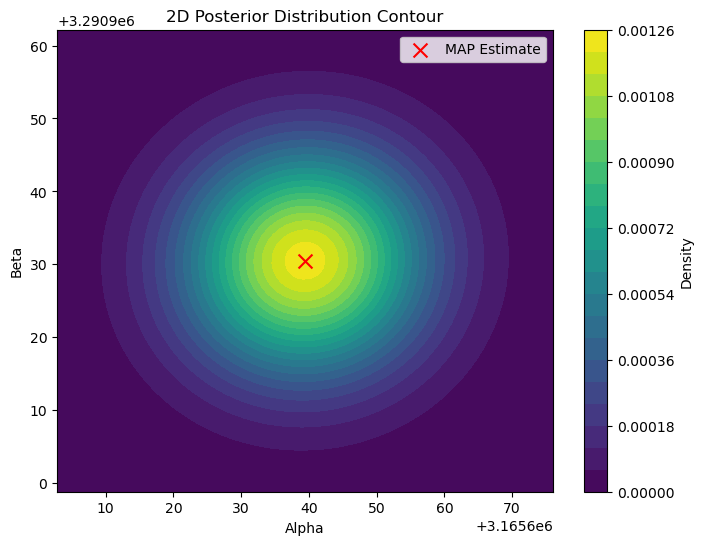

In [685]:
# indices for ALPHA_MAP and BETA_MAP to visualize
alpha_index = 0
beta_index = 1 

mean = mean_map[[alpha_index, beta_index]]
cov = cov_matrix[np.ix_([alpha_index, beta_index], [alpha_index, beta_index])]

x = np.linspace(mean[0] - 3 * np.sqrt(cov[0, 0]), mean[0] + 3 * np.sqrt(cov[0, 0]), 100)
y = np.linspace(mean[1] - 3 * np.sqrt(cov[1, 1]), mean[1] + 3 * np.sqrt(cov[1, 1]), 100)
X, Y = np.meshgrid(x, y)

pos = np.dstack((X, Y))
Z = multivariate_normal.pdf(pos, mean=mean, cov=cov)

plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(label='Density')
plt.scatter(mean[0], mean[1], color='red', marker='x', s=100, label='MAP Estimate')
plt.xlabel('Alpha')
plt.ylabel('Beta')
plt.title('2D Posterior Distribution Contour')
plt.legend()
plt.show()



In [686]:
print(alpha_samples[0,:])

[3165631.89043533 3290932.02602908 3171913.11893448 3445484.83788797
 2926236.38959991 2728801.13216813 2602807.64904499 2428266.97297167
 2136670.78108736 1841889.64242604 1426705.5862458  1143299.10231753
  926047.28604833  609371.8010704   460692.79062515  251626.06174117
  130884.41441586   69427.35696793  -18731.25212637  -40799.77316217
  -32471.76565863  -26223.84413137  -21852.45062203  -13483.70244417
  -10797.39987838  -10597.33604762   -9345.28941481]


In [687]:
print(beta_samples[0,:])

[26545281.23038968 27164163.75280333 26644019.64157026 28012719.20251
 25397491.96733193 24210358.83996721 23329628.23476141 22216183.43284561
 20423096.23791761 18684610.96251494 16294875.69442256 14157172.10845593
 12710405.99222388 10294320.80043377  8617212.16994385  7023378.09711826
  5702004.48297777  4616655.87695795  3663046.49386624  2907059.20734429
  2506477.01218226  1875101.51922916  1504463.49682199  1303858.55147462
   976257.96462311   783921.02333502   669166.84481251]


### Noisy Impedance Matrix

We generated K noisy realization of our true impedance vector `Z_true` to compute our noisy impedance matrix `Z_noisy`. To understand our rationale behind the choice of K, kindly refer to the model analysis. We set the noise_scale to 1 to test how our model performs under extreme noise levels.

In [688]:
K = 500
TRUE_CONCENTRATION = 0.9
NOISE_SCALE = 1

Z_true = MU_ALPHA * np.log(TRUE_CONCENTRATION, dtype=np.float64) + MU_BETA
Z_noisy = np.zeros((len(Z_true), K))

for k in range(K):
    epsilon_k = np.random.normal(0, SIGMA_EPSILON) # generate noise for each frequency (sample from Gaussian distribution)
    Z_noisy[:, k] = Z_true + (NOISE_SCALE * epsilon_k)

Z_noisy.shape

(27, 500)

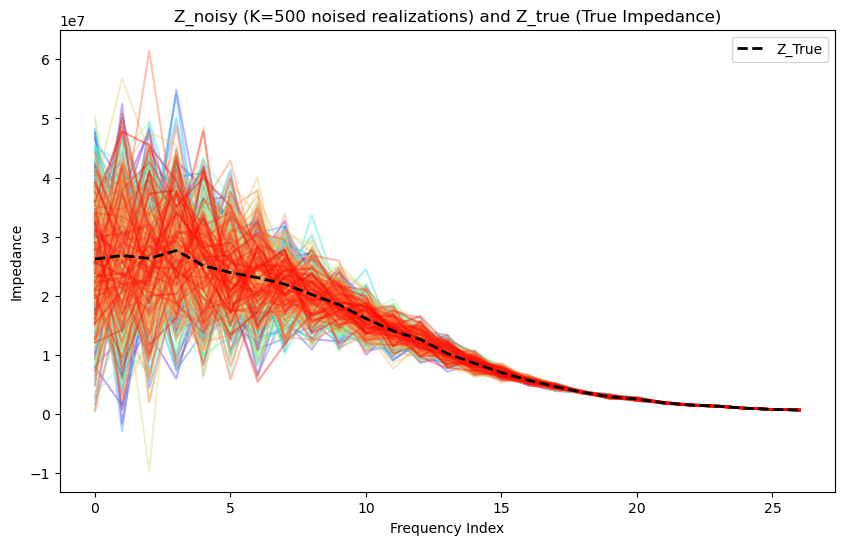

In [689]:
plt.figure(figsize=(10, 6))

for k in range(K):
    plt.plot(Z_noisy[:, k], color=plt.cm.rainbow(k / K), alpha=.4)

plt.plot(Z_true, 'k--', linewidth=2, label='Z_True')
plt.xlabel('Frequency Index')
plt.ylabel('Impedance')
plt.title(f'Z_noisy (K={K} noised realizations) and Z_true (True Impedance)')
plt.legend()
plt.show()


### Concentration Prediction

We now compute the concentration prediction for each frequency. Each of our K noisy realizations are predicted with each of N samples from the posterior, this leaves us with N*K prediction vectors. 

In [690]:
C_estimates = np.zeros((N, K, 27))

for i in range(N):
    for k in range(K):
        w = (alpha_samples[i, :], beta_samples[i, :])
        C_estimates[i, k, :] = predict_exp(Z_noisy[:, k], w)

In [691]:
print(C_estimates.shape)

(10, 500, 27)


Now that we have our concentration estimates under multiple noise and parameter realizations, we aggregate them into a single column vector `C_final` to guide us with the final concentration estimate at each frequency. Aggregating estimates again across all frequencies will give us the final concentration prediction. The following cells provide an analysis of the aggregation functions we utilize to find out which best fits the nature of the data. 

In [692]:
def estimate_uncertainty(C_estimates, C_final, C_pred, C_true, frequencies=np.arange(1, 28), visualize=True):

    C_median = np.median(C_final)
    C_hmean = hmean(C_final)
    C_gmean = gmean(C_final)
    C_mean = np.mean(C_final)

    variance = (1 / K) * (1 / N) * np.sum((C_final - C_pred)**2)

    confidence_interval = 1.96 * np.sqrt(variance)

    lower_bound = C_pred - confidence_interval
    upper_bound = C_pred + confidence_interval

    if visualize:

        print(f"We are 95% confident that our prediction of the concentration lies between {lower_bound} and {upper_bound}.")

        plt.figure(figsize=(12, 6))
        plt.plot(frequencies, C_final, label='Aggregated Concentration Estimate', color='blue', linewidth=2)
        plt.fill_between(frequencies, lower_bound, upper_bound, color='lightblue', alpha=0.5, label='95% Confidence Interval')
        plt.axhline(y=C_median, color='lightblue', linestyle='--', label=f'Median Concentration {C_median}')
        plt.axhline(y=C_hmean, color='green', linestyle='--', label=f'Harmonic Mean Concentration {C_hmean}')
        plt.axhline(y=C_gmean, color='red', linestyle='--', label=f'Geometric Mean Concentration {C_gmean}')
        plt.axhline(y=C_mean, color='yellow', linestyle='--', label=f'Arithmetic Mean Concentration {C_mean}')
        plt.axhline(y=C_pred, color='orange', linestyle='--', label=f'Predicted Concentration {C_pred}')
        plt.axhline(y=C_true, color='black', linestyle='-', label=f'True Concentration {C_true}')
        plt.title('Concentration Estimates with Uncertainty Estimation')
        plt.xlabel('Frequency Index')
        plt.ylabel('Concentration Estimate')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return confidence_interval

The arithmetic mean gives us aggregious CIs. We have to digress from our proposal here and figure out some other aggregation measure.

Predicted Concentration:  16.57042721832585
We are 95% confident that our prediction of the concentration lies between -90.54418573179144 and 123.68504016844314.


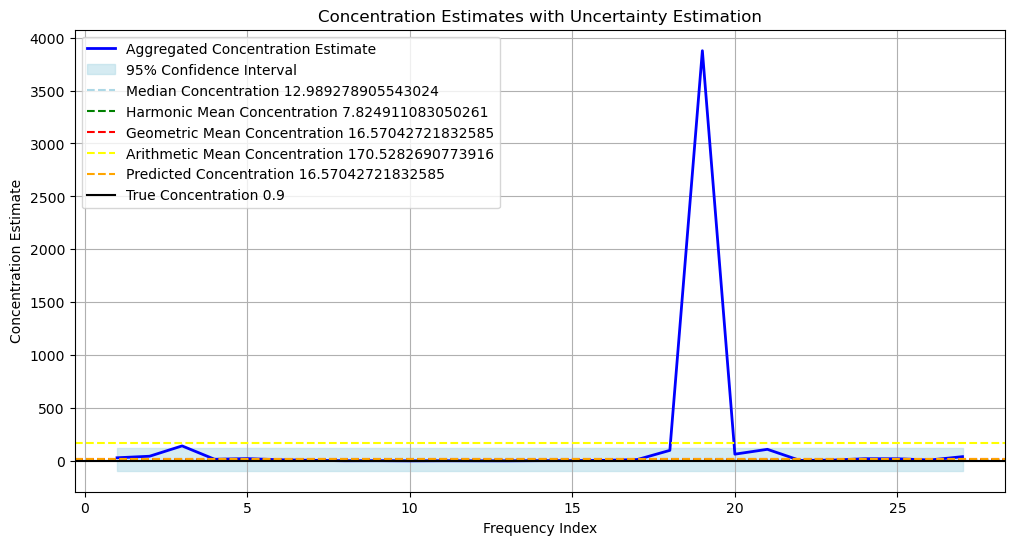

107.11461295011729

In [693]:
C_final = np.mean(C_estimates, axis=(0, 1))
C_aggregated = gmean(C_final)

print("Predicted Concentration: ", C_aggregated)

estimate_uncertainty(C_estimates, C_final, C_aggregated, TRUE_CONCENTRATION, frequencies=np.arange(1, C_final.shape[0] + 1))

Geometric Mean: performs much better than arithmetic mean for aggregating the estimates of concentration. 

Predicted Concentration:  1.0211964261787354
We are 95% confident that our prediction of the concentration lies between 0.9376241972021662 and 1.1047686551553046.


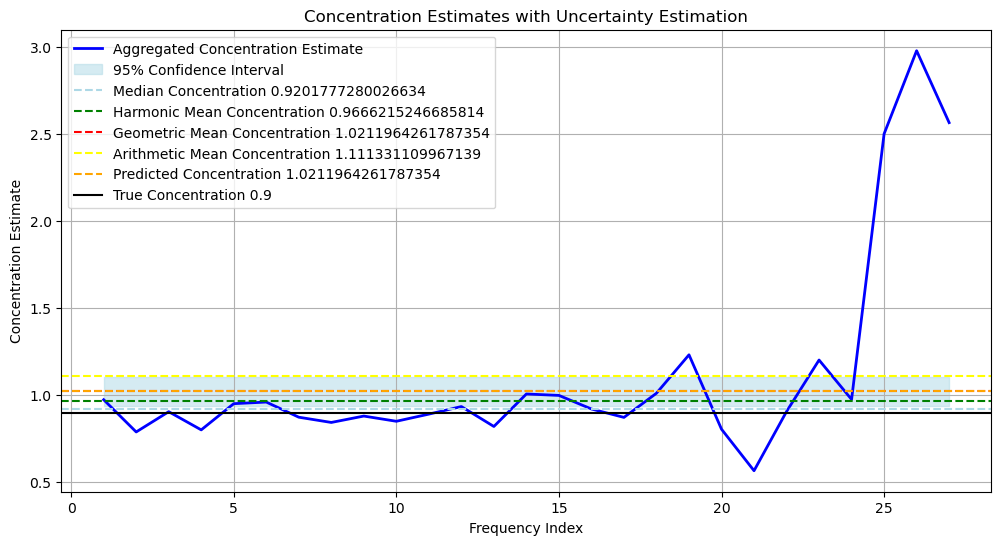

0.08357222897656919

In [695]:
C_final = gmean(C_estimates, axis=(0, 1))
C_aggregated = gmean(C_final)

print("Predicted Concentration: ", C_aggregated)

estimate_uncertainty(C_estimates, C_final, C_aggregated, TRUE_CONCENTRATION, frequencies=np.arange(1, C_final.shape[0] + 1))

Now we will experiment with some other aggregation functions for computing the final prediction

Median: performs much better and gives us a more accurate estimate as well as a tighter CI

Predicted Concentration:  0.9201777280026634
We are 95% confident that our prediction of the concentration lies between 0.8331502395305085 and 1.0072052164748184.


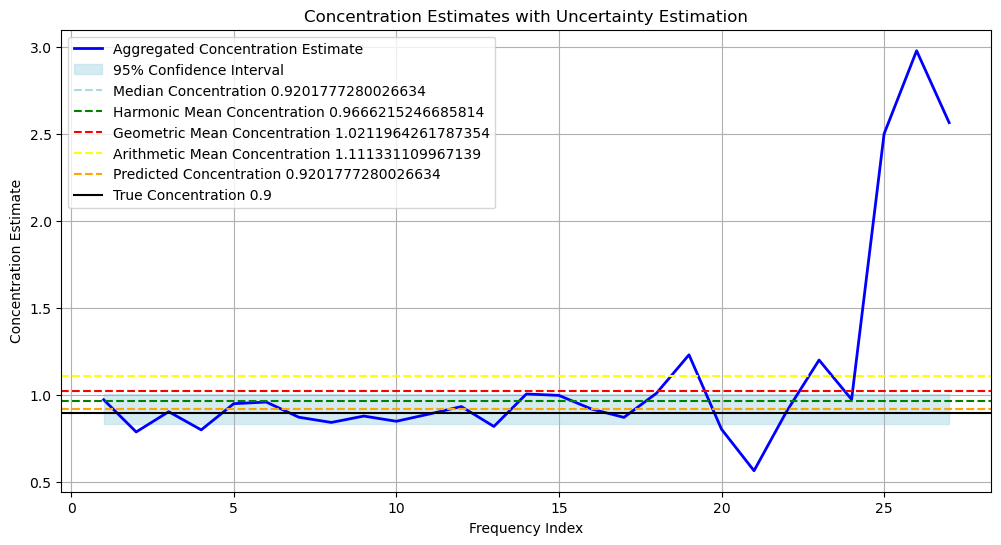

0.08702748847215494

In [694]:
C_final = gmean(C_estimates, axis=(0, 1))
C_aggregated = np.median(C_final)

print("Predicted Concentration: ", C_aggregated)

estimate_uncertainty(C_estimates, C_final, C_aggregated, TRUE_CONCENTRATION, frequencies=np.arange(1, C_final.shape[0] + 1))

Harmonic Mean: similar to geometric mean and median

Predicted Concentration:  0.9666215246685814
We are 95% confident that our prediction of the concentration lies between 0.8814734579355343 and 1.0517695914016285.


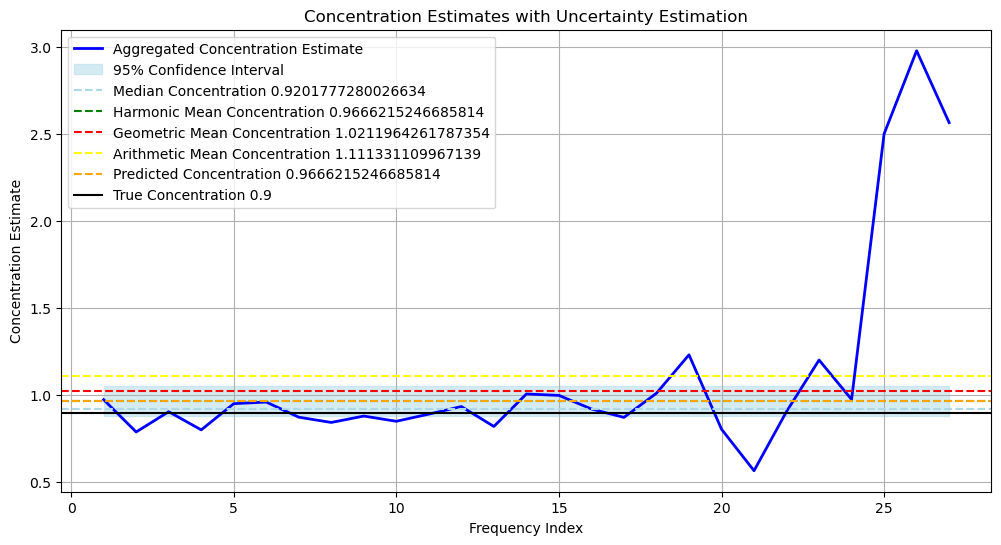

0.08514806673304706

In [696]:
C_final = gmean(C_estimates, axis=(0, 1))
C_aggregated = hmean(C_final)

print("Predicted Concentration: ", C_aggregated)

estimate_uncertainty(C_estimates, C_final, C_aggregated, TRUE_CONCENTRATION, frequencies=np.arange(1, C_final.shape[0] + 1))

For aggregation functions, we have to choose between harmonic mean, geometric mean, and median by finding out which performs the best consistently with the least error. We figure this out later on in the analysis to be the geometric mean. By now, we have implemented the probabilistic model completely and are now ready to experiment with it to recover the true concentration values from training data.

### Experiment

We experiment by treating the initial model as the ground truth to generate impedance at known concetrations and test how well our prediction algorithm works at recovering the true concentration from the noised data. We borrow some helper functions from the original sandbox for setting up the experiment.

In [702]:
concs = [c / 100 for c in range(1, 100, 10)] + [1]

m = len(concs)
n = len(freqs)

print("Concentrations: ", concs)
print("Frequencies: ", freqs)

def c_to_z(c, freq_idx, weights=weights):
    """
    Wrapper utility function mapping (concentration) ==> (impedance) at a given frequency.
    Simply calls the fitted logarithmic function.
    """
    return predict_log(c, weights[freq_idx])

def freq_sweep_at_c(c, weights=weights):
    """
    Mimics a biosensing experiment at a single concentration c > 0. Note that the sweep doesn't impart any error.
    Any impedance values are exactly generated from the model.
    
    Input: Concentration C
           Set of weights describing the function (concentration) ==> (impedance) at each frequency.
           
    Output: A list of impedance values, one for each frequency.
    """
    assert c > 0
    return np.array([c_to_z(c, i, weights) for i in range(len(freqs))])

def generate_experiment(concs, weights=weights):
    """
    Generates an (m x n) data matrix with impedance values.
    Each row represents a single concentration.
    Each col represents a single frequency.
    """
    m = len(concs)
    n = freqs.shape[0]
    Z = np.empty((m, n))
    for i, c in enumerate(concs):
        Z[i] = freq_sweep_at_c(c, weights)
    return Z

def generate_noise(m, n, noise_at_freq):
    """
    Return matrix of noise at each concentration (rows) and frequency (cols).
    """
    noises = np.empty((m, n))
    zeros = np.zeros(n)
    for i in range(m):
        noises[i] = np.random.normal(zeros, 
                                     )
        
    return noises

def avg_noise(n_samples, noise_at_freq):
    """
    Repeatedly generate noise for n_samples and return the average.
    By the central limit theorem, as n_samples increases, average_noise should return to zero.
    
    n_samples is limited to 1000 to avoid overflow issues, as the noise scale is quite large at around 10^6
    """
    assert n_samples <= 1000
    
    agg = np.zeros((m, n))
    for i in range(n_samples):
        agg += generate_noise(m, n, noise_at_freq) / n_samples
    
    return agg

def fit(X, y):
    """
    Fits a linear model to the data.
    """
    m, n = X.shape
    
    assert y is not None and len(y) == m, "Must input valid concentrations"
    
    w = np.empty((n, 2))
    
    for i in range(n):
        w[i] = fit_log(np.array(y), X[:,i])
        
    return w

train_noise_scale = 0.4
n_samples = 9

noises = avg_noise(n_samples, noise_at_freq)

# Generate true data at known concentrations CONCS and frequencies FREQS

X_true = generate_experiment(concs)
y_true = np.array(concs)

X = X_true + train_noise_scale * noises
weights = fit(X, y_true)
print("Weights: ", weights)

Concentrations:  [0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1]
Frequencies:  [  100.      127.      161.291   204.842   260.151   330.394   419.603
   532.899   676.786   859.524  1091.6    1386.35   1760.67   2236.07
  2839.82   3606.6    4580.41   5817.16   7387.84   9382.62  11916.
 15133.42  19219.57  24409.02  30999.65  39369.82  50000.   ]
Weights:  [[ 3.16563947e+06  2.65452658e+07]
 [ 3.29093047e+06  2.71642119e+07]
 [ 3.17189122e+06  2.66440198e+07]
 [ 3.44548976e+06  2.80127386e+07]
 [ 2.92623456e+06  2.53974894e+07]
 [ 2.72880705e+06  2.42103551e+07]
 [ 2.60318435e+06  2.33296179e+07]
 [ 2.42826017e+06  2.22161762e+07]
 [ 2.13665775e+06  2.04231026e+07]
 [ 1.84189064e+06  1.86846073e+07]
 [ 1.42669475e+06  1.62948662e+07]
 [ 1.14332238e+06  1.41571709e+07]
 [ 9.26062425e+05  1.27103892e+07]
 [ 6.09373099e+05  1.02943275e+07]
 [ 4.60682908e+05  8.61722759e+06]
 [ 2.52061325e+05  7.02337022e+06]
 [ 1.31276261e+05  5.70200516e+06]
 [ 6.94119563e+04  4.61662538

In the following `predict` method, we put our entire logic together.

In [706]:
def predict(Z, concentrations, weights, C_true, N, K, num_frequencies, sigma_epsilon, noise_scale, agg_fn):

    noise_variance = sigma_epsilon ** 2

    MU_ALPHA = weights[:, 0]
    MU_BETA = weights[:, 1]

    SIGMA_ALPHA = 0.1 * np.abs(MU_ALPHA)  
    SIGMA_BETA = 0.1 * np.abs(MU_BETA)    

    initial_params = np.hstack((MU_ALPHA, MU_BETA)) 

    result = minimize(combined_log_posterior, initial_params, args=(Z, list(concentrations), noise_variance, MU_ALPHA, SIGMA_ALPHA, MU_BETA, SIGMA_BETA), method='L-BFGS-B')

    hess_MAP = hessian(combined_log_posterior, result.x, Z, concentrations, noise_variance, MU_ALPHA, SIGMA_ALPHA, MU_BETA, SIGMA_BETA)

    cov_matrix = inv(hess_MAP)

    ALPHA_MAP = result.x[:num_frequencies] 
    BETA_MAP = result.x[num_frequencies:]  

    mean_map = np.concatenate([ALPHA_MAP, BETA_MAP])

    samples = np.random.multivariate_normal(mean_map, cov_matrix, N)

    alpha_samples = samples[:, :num_frequencies]
    beta_samples = samples[:, num_frequencies:] 

    Z_true = MU_ALPHA * np.log(C_true, dtype=np.float64) + MU_BETA
    Z_noisy = np.zeros((len(Z_true), K))

    for k in range(K):
        epsilon_k = np.random.normal(0, SIGMA_EPSILON)
        Z_noisy[:, k] = Z_true + (noise_scale * epsilon_k)

    C_estimates = np.zeros((N, K, 27))

    for i in range(N):
        for k in range(K):
            C_estimates[i, k, :] = np.exp((Z_noisy[:, k] - beta_samples[i, :]) / alpha_samples[i, :])

    C_final = gmean(C_estimates, axis=(0, 1))
    C_aggregated = agg_fn(C_final)

    confidence_interval = estimate_uncertainty(C_estimates, C_final, C_aggregated, C_true, frequencies=np.arange(1, C_final.shape[0] + 1), visualize=False)
    
    lower_bound = C_aggregated - confidence_interval
    upper_bound = C_aggregated + confidence_interval

    error = np.abs(C_aggregated - C_true)

    return C_final, C_aggregated, error, confidence_interval, lower_bound, upper_bound


Result: Under extremely high noise scales, the algorithm is successful in retrieving true concentration value.

In [711]:
SIGMA_EPSILON = noise_at_freq
NUM_FREQUENCIES = len(freqs)
NUM_PARAMS = 2 # alpha and beta
NOISE_VARIANCE = SIGMA_EPSILON ** 2
AGG_FUNCS = [hmean, gmean, np.median]
N = 10
K = 500
TRUE_CONCENTRATION = 0.42
NOISE_SCALE = 2.5

test_preds, prediction, error, confidence_interval, lower_bound, upper_bound = predict(X, np.array(concs), weights, TRUE_CONCENTRATION, N, K, NUM_FREQUENCIES, SIGMA_EPSILON, NOISE_SCALE, AGG_FUNCS[1])

print("Noise Scale: ", NOISE_SCALE)
print("True Concentration: ", TRUE_CONCENTRATION)
print("Predicted Concentration: ", prediction)
print("Error: ", error)
print(f"We are 95 percent confident that the true value of concentration lies between {lower_bound} and {upper_bound}")
print("Width of CI: ", upper_bound - lower_bound)

Noise Scale:  2.5
True Concentration:  0.42
Predicted Concentration:  0.4170981039436421
Error:  0.0029018960563578777
We are 95 percent confident that the true value of concentration lies between 0.39497514875004014 and 0.4392210591372441
Width of CI:  0.044245910387203935


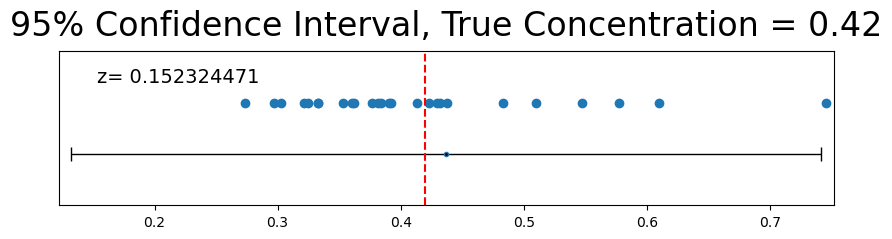

In [712]:
mu = np.mean(test_preds)
z = np.std(test_preds)

def plot_confidence(mu, z, true_conc, test_preds=test_preds, x_window='auto'):
    fig, ax = plt.subplots(1, 1, figsize=(10, 2))
    ax.errorbar(mu, 0, xerr=2*z, marker='o', mfc='k', ms=3, lw=1, capsize=5, capthick=1, ecolor='k')
    ax.scatter(test_preds, np.full(len(test_preds), 0.1))
    ax.axvline(true_conc, ls='--', c='r')
    plt.text(0.05,
         0.8,
         f"z={z: .9f}",
             size=14,
         transform=plt.gca().transAxes)

    ax.set_title(f"95% Confidence Interval, True Concentration = {true_conc}", size=24, y=1.05)
    if x_window == 'auto':
        ax.set_xlim(mu - 2*z - 0.01, mu + 2*z + 0.01)
    else:
        ax.set_xlim(0.01, 1)
    ax.get_yaxis().set_visible(False)
    ax.set_ylim(-0.1, 0.2)

plot_confidence(mu, z, TRUE_CONCENTRATION)

### Model Analysis

In this section, we tune the values of K and N as well as decide which agg function performs ideally. We observe how each function performs under varying noise levels (from 0.1 to 2.5)

Analyzing noise factors: 100%|██████████| 25/25 [01:26<00:00,  3.47s/it]


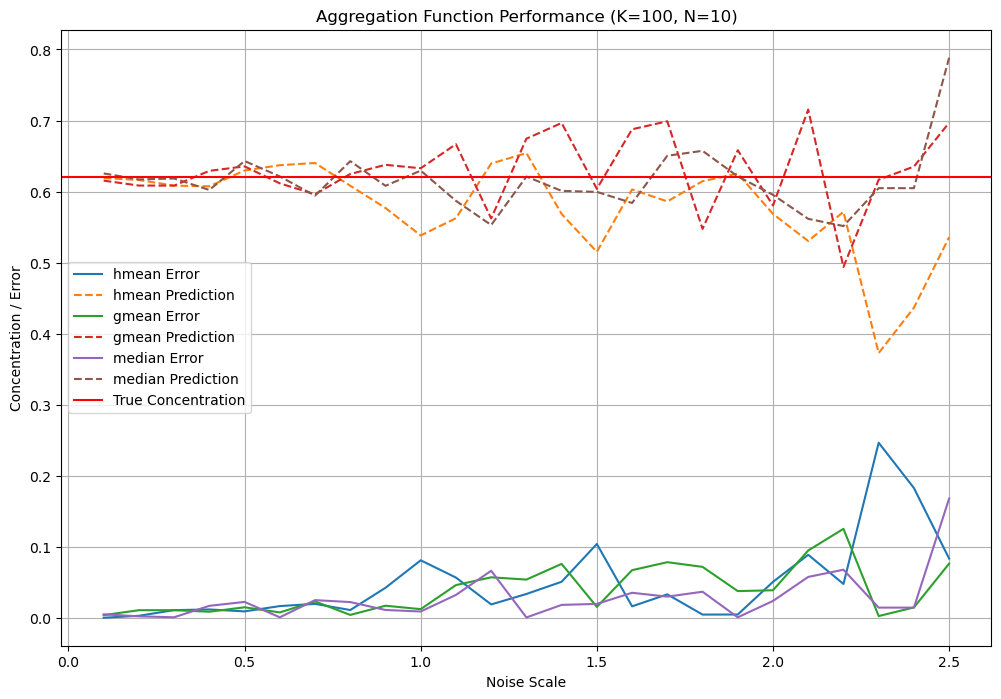

In [549]:
def evaluate_model(agg_fn, noise_scale, K, N):
    prediction, error, confidence_interval, lower_bound, upper_bound = predict(
        X, np.array(concs), weights, TRUE_CONCENTRATION, N, K, 
        NUM_FREQUENCIES, SIGMA_EPSILON, noise_scale, agg_fn
    )
    return prediction, error, confidence_interval

def plot_noise_factor_analysis(agg_funcs, K, N):
    noise_factors = np.arange(0.1, 2.6, 0.1)
    results = {func.__name__: [] for func in agg_funcs}

    for noise_scale in tqdm(noise_factors, desc="Analyzing noise factors"):
        for func in agg_funcs:
            prediction, error, _ = evaluate_model(func, noise_scale, K, N)
            results[func.__name__].append((prediction, error))

    plt.figure(figsize=(12, 8))
    for func_name, data in results.items():
        predictions, errors = zip(*data)
        plt.plot(noise_factors, errors, label=f'{func_name} Error')
        plt.plot(noise_factors, predictions, label=f'{func_name} Prediction', linestyle='--')

    plt.axhline(y=TRUE_CONCENTRATION, color='r', linestyle='-', label='True Concentration')
    plt.xlabel('Noise Scale')
    plt.ylabel('Concentration / Error')
    plt.title(f'Aggregation Function Performance (K={K}, N={N})')
    plt.legend()
    plt.grid(True)
    plt.show()

agg_funcs = [hmean, gmean, np.median]

plot_noise_factor_analysis(agg_funcs, K=100, N=10)

Increasing N to 100 does not improve the error deviations as much as we would like.

Analyzing noise factors: 100%|██████████| 25/25 [01:26<00:00,  3.47s/it]


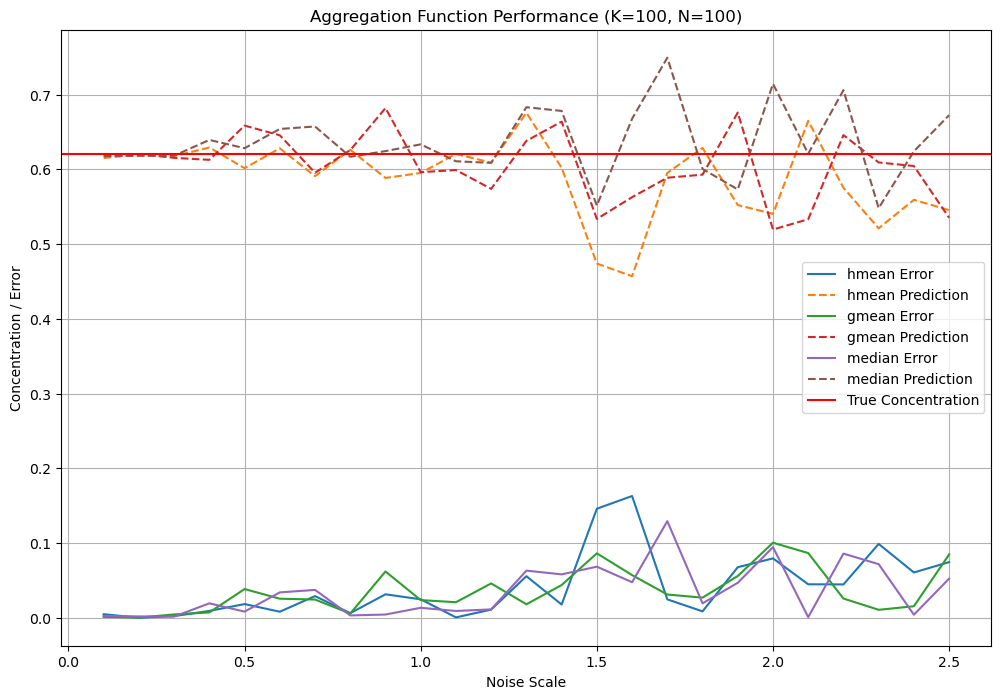

In [552]:
plot_noise_factor_analysis(agg_funcs, K=100, N=100)

Reducing both K and N give extreme deviations. 

Analyzing noise factors: 100%|██████████| 25/25 [01:26<00:00,  3.47s/it]


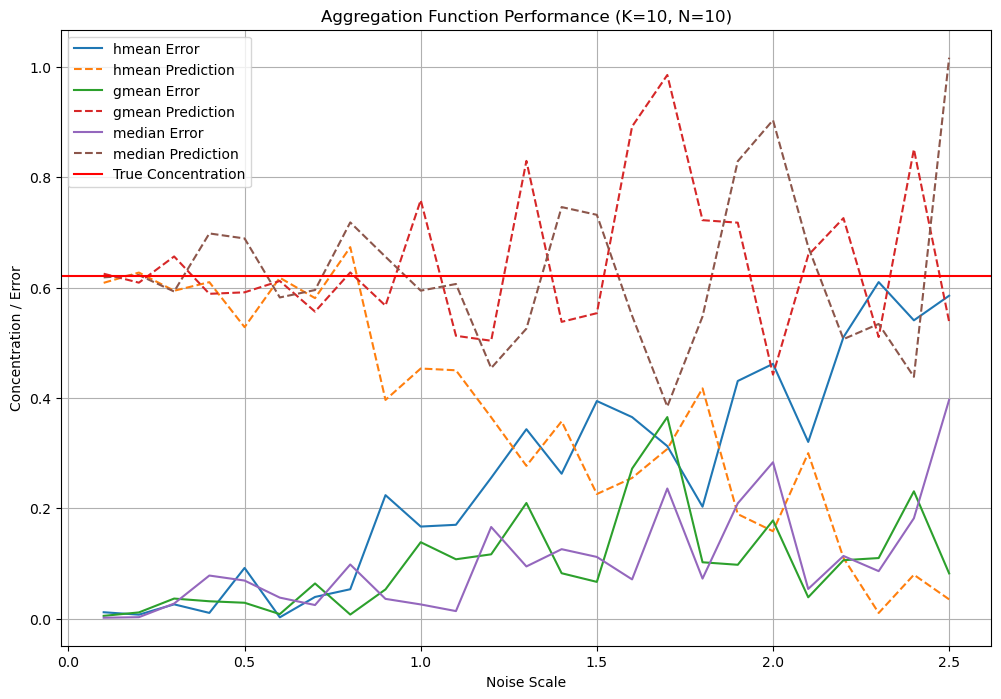

In [553]:
plot_noise_factor_analysis(agg_funcs, K=10, N=10)

Increasing K to 1000 greatly compresses our deviations. However, we can see if we can reduce this value to a reasonable value where the computational overhead is negligible.

Analyzing noise factors: 100%|██████████| 25/25 [01:28<00:00,  3.55s/it]


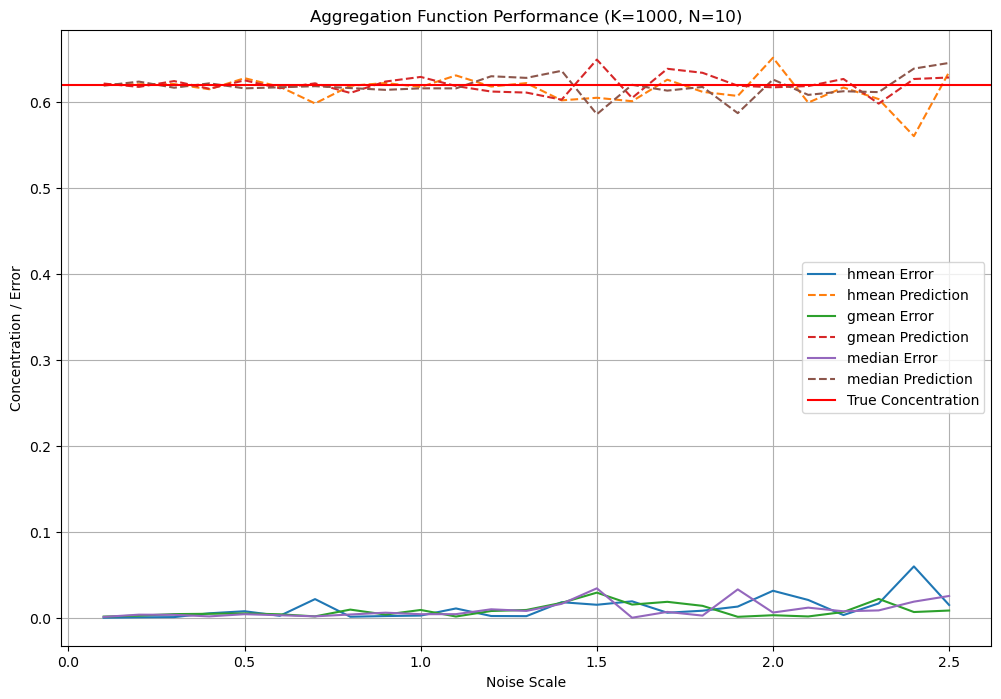

In [554]:
plot_noise_factor_analysis(agg_funcs, K=1000, N=10)

We are able to find a sweet spot at K=500 and N=10 where the deviations are negligible and computational cost is also minimal (N*K = 5000 vectors). For the aggregation functions, all are very similar, but the geometric mean offers a marginally better peak error deviation so we choose it. 

Analyzing noise factors: 100%|██████████| 25/25 [01:27<00:00,  3.51s/it]


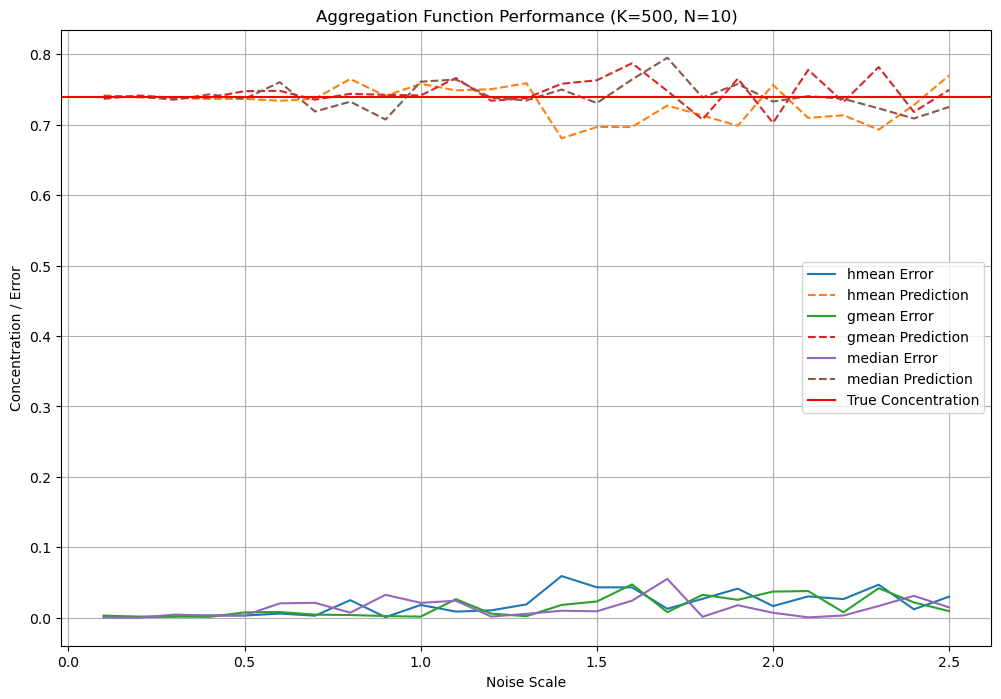

In [556]:
plot_noise_factor_analysis(agg_funcs, K=500, N=10)